# Mentoria DiploDatos FAMAF

## Reducción de Emisiones Contaminantes por el Uso de Biocombustibles en Transporte de Cargas y Pasajeros

### Práctico de Análisis y Visualización

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!pip install pymysql
import pymysql as sql

## Datos propios
_Datasets :_
- Usuarios: registra datos de los usuarios de las bombas
- Vehiculos: registra datos de los vehículos 
- Productos: registra datos de los tipos de combustibles
- Equipos: registra datos de los equipos IoT
- Tanques: registra datos de los tanques de almacenamiento
- Bombas: registra datos de las bombas de suministro de combustible
- Transacciones (mensuales, desde el 2018): registro de los suministros de combustible por cada bomba a cada vehículo
- Historial (mensuales, desde el 2018): registro de los inventarios mensuales de los tanques de combustibles

In [4]:
# Listado de todas las tablas de la base de datos
DB_HOST = 'localhost'
DB_PORT = 33060
DB_USER = 'superset'
DB_PASS = 'superset'
DB_NAME = 'db'

mysqldb = sql.connect(
  host=DB_HOST,
  port=DB_PORT,
  user=DB_USER,
  passwd=DB_PASS,
  database=DB_NAME
)
mysqlcursordb = mysqldb.cursor()
mysqlcursordb.execute("show tables")
lista_tablas = []
for tabla in mysqlcursordb:
    lista_tablas.append(tabla[0])
print(lista_tablas)

['fs_asignacion_producto', 'fs_bombas', 'fs_equipo', 'fs_tanques', 'fs_usuarios_fuelsentry', 'fs_vehiculos', 'sis_historial_2018_1', 'sis_historial_2018_10', 'sis_historial_2018_11', 'sis_historial_2018_12', 'sis_historial_2018_2', 'sis_historial_2018_3', 'sis_historial_2018_4', 'sis_historial_2018_5', 'sis_historial_2018_6', 'sis_historial_2018_7', 'sis_historial_2018_8', 'sis_historial_2018_9', 'sis_historial_2019_1', 'sis_historial_2019_10', 'sis_historial_2019_11', 'sis_historial_2019_12', 'sis_historial_2019_2', 'sis_historial_2019_3', 'sis_historial_2019_4', 'sis_historial_2019_5', 'sis_historial_2019_6', 'sis_historial_2019_7', 'sis_historial_2019_8', 'sis_historial_2019_9', 'sis_historial_2020_1', 'sis_historial_2020_2', 'sis_historial_2020_3', 'sis_historial_2020_4', 'sis_historial_2020_5', 'sis_transa_2018_1', 'sis_transa_2018_10', 'sis_transa_2018_11', 'sis_transa_2018_12', 'sis_transa_2018_2', 'sis_transa_2018_3', 'sis_transa_2018_4', 'sis_transa_2018_5', 'sis_transa_2018_6

In [5]:
# Recuperar los 10 primeros registros de una tabla de la base de datos
mysqlcursordb = mysqldb.cursor()
query_registros = "SELECT * FROM fs_bombas;"
mysqlcursordb.execute(query_registros)
registros  = mysqlcursordb.fetchall()
for reg in registros[0:10]:
    print(reg)

(1, 333333, '01', '0', 1, '0031731.441', datetime.date(2012, 7, 19), '0000', '2.0', '1', '0000')
(2, 333333, '02', '0', 1, '1160601.525', datetime.date(2012, 7, 19), '0000', '2.0', '1', '0000')
(11417, 770, '02', '1', 101856, '0000000.000', datetime.date(2018, 7, 5), '0026.3158', '020', '1', '0000')
(5, 444444, '01', '2', 4, '0651995.027', datetime.date(2010, 12, 1), '35.0', '888', '1', '0000')
(6, 444444, '02', '2', 4, '0005232.793', datetime.date(2010, 12, 1), '35.5', '2.0', '1', '0000')
(7, 444444, '03', '3', 5, '0000090.979', datetime.date(2010, 12, 1), '35.0', '1.0', '1', '0000')
(8, 444444, '04', '4', 6, '0000000.338', datetime.date(2010, 12, 1), '35.0', '1.0', '1', '0000')
(9, 444444, '05', '5', 7, '0000000.001', datetime.date(2010, 12, 1), '35.0', '1.0', '1', '0000')
(10, 444444, '06', '1', 3, '0651995.027', datetime.date(2010, 12, 1), '35.0', '2.0', '2', '0001')
(11, 444444, '07', '1', 3, '0651995.027', datetime.date(2010, 12, 1), '35.0', '2.0', '0', '0003')


In [6]:
# Conexión a la base de datos (para MySQL)
from sqlalchemy import create_engine

# Crear motor de conexión sqlalchemy
path_conexion = 'mysql+pymysql://{}:{}@{}:{}/{}'.format(
    DB_USER, DB_PASS, DB_HOST, DB_PORT, DB_NAME
)
conexion = create_engine(path_conexion)

Para este primer práctico estaremos trabajando solo con algunos datasets. En el segundo práctico se incorporará otros datasets, que requieren de mayor limpieza y manipulacion de los datos.

In [7]:
# Listado de querys para consultas de las tablas a analizar
query_productos = "SELECT * FROM fs_asignacion_producto;"
query_bombas = "SELECT * FROM fs_bombas;"
query_tanques = "SELECT * FROM fs_tanques;"
query_usuarios = "SELECT * FROM fs_usuarios_fuelsentry;"
query_vehiculos = "SELECT * FROM fs_vehiculos;"

In [8]:
# Obtención de dataframe 'fs_asignacion_producto', 'fs_bombas', 'fs_equipo', 'fs_tanques', 'fs_usuarios_fuelsentry', 'fs_vehiculos'
df_productos = pd.read_sql_query(query_productos, path_conexion)
df_tanques = pd.read_sql_query(query_tanques, path_conexion)
df_usuarios = pd.read_sql_query(query_usuarios, path_conexion)

# También podemos pasar el tipo de formato de las fechas para su conversión al momento de leer los datos
format_string = "%Y-%m-%d %H:%M:%S"
df_bombas = pd.read_sql_query(query_bombas, path_conexion, parse_dates={'fecha_reinicio': format_string})
df_vehiculos = pd.read_sql_query(query_vehiculos, path_conexion)

In [9]:
pd.set_option('display.max_columns', 50)

### Dataset de asignación de productos:

Contiene información relacionada con los productos de combustible.

Descripción de las columnas:
- 'id_equipo': ID del dispositivo IoT
- 'producto': código del producto
- 'nombre_producto': nombre del producto
- 'codigo': 
- 'precio_litro': precio del producto (en $/l)
- 'coef_var_vol': coeficiente de variación del volumen del producto combustible (en g/ml/°C)
- 'density': densidad del producto (en g/ml)

Densidad (ASTM D 4052): densidad relativa del combustible medido (en g/ml o kg/m3) a la temperatura estándar de 15 °C.

In [10]:
print(f'Dimensión del dataset (filas, columnas): {df_productos.shape}\n')
print(f'{df_productos.info()}\n')
df_productos.head()

Dimensión del dataset (filas, columnas): (2672, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_equipo        2672 non-null   int64  
 1   producto         2672 non-null   object 
 2   nombre_producto  2672 non-null   object 
 3   codigo           2526 non-null   object 
 4   precio_litro     2672 non-null   float64
 5   coef_var_vol     2672 non-null   float64
 6   density          249 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 146.2+ KB
None



,id_equipo,producto,nombre_producto,codigo,precio_litro,coef_var_vol,density
0,333333,0,gas oil,gas oil,7.5,0.001,NaN
1,333333,1,Product 2,Product 2,0.0,0.001,NaN
2,333333,2,Product 3,Product 3,0.0,0.001,NaN
3,333333,3,Product 4,Product 4,0.0,0.001,NaN
4,1,0,Diesel,Diesel,1.0,0.001,NaN


In [11]:
# Valores o categorias unicas para cada columna
for i in df_productos.columns:
    print(f'{i}: {df_productos[i].nunique()}')

id_equipo: 702
producto: 10
nombre_producto: 142
codigo: 143
precio_litro: 76
coef_var_vol: 5
density: 3


### Dataset de bombas:

Contiene información de las bombas de suministro de combustible.

--> Un punto de suministro del combustible posee uno o varios equipos (dispositivo IoT) 

Descripción de las columnas:
- 'id_bomba': ID de la bomba
- 'id_equipo': ID del dispositivo IoT
- 'bomba': 
- 'producto': tipo de combustible que suministra la bomba
- 'id_tanque': ID del tanque
- 'totalizador': litros suministrados a la fecha de reinicio
- 'fecha_reinicio': fecha de reinicio de la bomba
- 'pulsos_litro': litros que suministra la bomba (por pulso)
- 'tiempo_interrump': tiempo de interrupción del suministro de combustible de la bomba (en segundos)
- 'habilitacion': 
- 'rampa_de_parada'

In [12]:
print(f'Dimensión del dataset (filas, columnas): {df_bombas.shape}\n')
print(f'{df_bombas.info()}\n')
df_bombas.head()

Dimensión del dataset (filas, columnas): (1438, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_bomba          1438 non-null   int64         
 1   id_equipo         1438 non-null   int64         
 2   bomba             1438 non-null   object        
 3   producto          1438 non-null   object        
 4   id_tanque         1438 non-null   int64         
 5   totalizador       1438 non-null   object        
 6   fecha_reinicio    1435 non-null   datetime64[ns]
 7   pulsos_litro      1438 non-null   object        
 8   tiempo_interrump  1438 non-null   object        
 9   habilitacion      1438 non-null   object        
 10  rampa_de_parada   1438 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 123.7+ KB
None



,id_bomba,id_equipo,bomba,producto,id_tanque,totalizador,fecha_reinicio,pulsos_litro,tiempo_interrump,habilitacion,rampa_de_parada
0,1,333333,01,0,1,0031731.441,2012-07-19,0000,2.0,1,0000
1,2,333333,02,0,1,1160601.525,2012-07-19,0000,2.0,1,0000
2,11417,770,02,1,101856,0000000.000,2018-07-05,0026.3158,020,1,0000
3,5,444444,01,2,4,0651995.027,2010-12-01,35.0,888,1,0000
4,6,444444,02,2,4,0005232.793,2010-12-01,35.5,2.0,1,0000


In [13]:
# Valores o categorias unicas para cada columna
for i in df_bombas.columns:
    print(f'{i}: {df_bombas[i].nunique()}')

id_bomba: 1438
id_equipo: 610
bomba: 28
producto: 11
id_tanque: 861
totalizador: 869
fecha_reinicio: 179
pulsos_litro: 245
tiempo_interrump: 29
habilitacion: 7
rampa_de_parada: 7


### Dataset de tanques:

Contiene información de los tanques de combustible.

--> Una empresa puede tener más de un tanque

--> Varios tanques pueden estar conectado a un mismo equipo

--> Un tanque posee una o varias bombas

Descripción de las columnas:
- 'id_tanque': ID del tanque
- 'id_equipo': ID del dispositivo IoT 
- 'tanque': tipo de tanque
- 'producto': producto almacenado en el tanque 
- 'capacidad': capacidad del tanque en litros
- 'log_interval': intervalo de tiempo en el cual se registra la medición del volumen del contenido del tanque --> historial del volumen del tanque
- 'nivel_alarma': nivel de contenido del tanque para disparar alarma

In [14]:
print(f'Dimensión del dataset: {df_tanques.shape}\n')
print(f'{df_tanques.info()}\n')
df_tanques. head()

Dimensión del dataset: (1561, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_tanque     1561 non-null   int64 
 1   id_equipo     1561 non-null   int64 
 2   tanque        1561 non-null   object
 3   producto      1561 non-null   object
 4   capacidad     1561 non-null   object
 5   log_interval  1561 non-null   object
 6   nivel_alarma  1561 non-null   object
dtypes: int64(2), object(5)
memory usage: 85.5+ KB
None



,id_tanque,id_equipo,tanque,producto,capacidad,log_interval,nivel_alarma
0,101525,669,B,1,0010000.1,0030,0
1,101833,764,5,1,0008000.0,0030,000003200
2,101496,662,1,0,0050000.0,0030,0
3,101495,661,1,0,0025000.0,0030,0
4,101522,669,8,1,0010000.1,0030,0


In [15]:
for i in df_tanques.columns:
    print(f'{i}: {df_tanques[i].nunique()}')

id_tanque: 1561
id_equipo: 638
tanque: 18
producto: 10
capacidad: 158
log_interval: 18
nivel_alarma: 102


### Dataset de usuarios:

Contiene información de los usuarios de las bombas de combustible.

Descripción de las columnas:
- 'id_usuario_fuelsentry': ID de registro del usuario
- 'id_equipo':  ID del dispositivo IoT
- 'usuario_fuelsentry': código del usuario de la bomba
- 'departamento': 
- 'codigo': 
- 'totalizador': litros totales suministrados por el usuario de la bomba
- 'cargas_totales': número total de cargas sumnistradas por el usuario

In [16]:
print(f'Dimensión del dataset: {df_usuarios.shape}\n')
print(f'{df_usuarios.info()}\n')
df_usuarios. head()

Dimensión del dataset: (13623, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13623 entries, 0 to 13622
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id_usuario_fuelsentry  13623 non-null  int64 
 1   id_equipo              13623 non-null  int64 
 2   usuario_fuelsentry     13623 non-null  object
 3   departamento           13623 non-null  object
 4   codigo                 13623 non-null  object
 5   totalizador            13623 non-null  object
 6   cargas_totales         13623 non-null  object
dtypes: int64(2), object(5)
memory usage: 745.1+ KB
None



,id_usuario_fuelsentry,id_equipo,usuario_fuelsentry,departamento,codigo,totalizador,cargas_totales
0,2,333333,0001,0000,0000,00323.152,001
1,3,333333,1315,0001,2012,01655.590,009
2,4,333333,1312,0001,4468,01433.429,006
3,5,333333,1298,0001,2609,00412.834,002
4,6,333333,0818,0001,1978,00713.023,003


In [17]:
for i in df_usuarios.columns:
    print(f'{i}: {df_usuarios[i].nunique()}')

id_usuario_fuelsentry: 13623
id_equipo: 509
usuario_fuelsentry: 3527
departamento: 64
codigo: 594
totalizador: 4523
cargas_totales: 549


## Dataset de Vehiculos

Contiene informacion sobre los vehiculos 

Descripcion de las columnas:
- **id_vehiculo:** identificador unico
- **id_equipo:** el vehiculo esta asociado a un equipo, poede decirse que esta asociado a una estacion de carga
- **vehiculo:** corresponde a una identificacion local del vehiculo por parte del equipo.
- **departamento:** agrupacion por departamento. campo propio del cliente.
- **limite:**
- **odometro_inicio:**
- **odometro_fin:**
- **cargas_maximas_dia:**
- **autorizacion:** [campo en desuso]
- **cargas_hoy:** [campo en desuso]
- **cargas_hasta_hoy:** [campo en desuso]
- **ultima_fecha:** [campo en desuso]


In [18]:
print(f'Dimensión del dataset: {df_vehiculos.shape}\n')
print(f'{df_vehiculos.info()}\n')
df_vehiculos.head()

Dimensión del dataset: (50627, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50627 entries, 0 to 50626
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_vehiculo       50627 non-null  int64 
 1   id_equipo         50627 non-null  int64 
 2   vehiculo          50627 non-null  object
 3   departamento      50627 non-null  object
 4   limite            50627 non-null  object
 5   odometro_inicio   50627 non-null  object
 6   odometro_fin      50627 non-null  object
 7   cargas_max_dia    50627 non-null  object
 8   autorizacion      50627 non-null  object
 9   cantidad_total    50627 non-null  object
 10  cargas_hoy        50627 non-null  object
 11  cargas_hasta_hoy  50627 non-null  object
 12  ultima_fecha      50627 non-null  object
dtypes: int64(2), object(11)
memory usage: 5.0+ MB
None



,id_vehiculo,id_equipo,vehiculo,departamento,limite,odometro_inicio,odometro_fin,cargas_max_dia,autorizacion,cantidad_total,cargas_hoy,cargas_hasta_hoy,ultima_fecha
0,2,333333,MDAwMDAx,0001,9,193958,193958,99,0,00000.000,01,000,2018-12-20
1,3,333333,MDAwMjM5,0001,9,079345,079345,99,0,00000.000,02,000,2018-12-20
2,4,333333,MDAwMjcw,0001,9,842409,842409,99,0,00000.000,01,000,2018-12-20
3,5,333333,MDAwMjUy,0001,9,287596,287596,99,0,00000.000,02,000,2018-12-20
4,6,333333,MDAwMjM1,0001,9,235878,235878,99,0,00000.000,01,000,2018-12-20


## Datos públicos:
Bioetanol: producción y ventas (total país)
- Producción y ventas de bioetanol por mes en base a maíz y caña de azúcar (en metros cúbicos).
- Frecuencia de actualización: Mensualmente
- Último cambio: 15 de mayo de 2018

In [38]:
url_bioetanol_nacional = 'http://datos.minem.gob.ar/dataset/5ce77ad1-c729-42cd-a8b5-2407de005e5b/resource/fd142c49-fa73-4e21-be1f-a10d6d67d05d/download/bioetanol-serie-produccion-y-ventas-total-pais.csv'
bioetanol_nacional=pd.read_csv(url_bioetanol_nacional, parse_dates=['mes'])
print(f'Dimensión del dataset (filas, columnas): {bioetanol_nacional.shape}\n')
print(f'{bioetanol_nacional.info()}\n')
bioetanol_nacional.head()

Dimensión del dataset (filas, columnas): (101, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   mes                              101 non-null    datetime64[ns]
 1   unidades                         101 non-null    object        
 2   produccion_total                 101 non-null    float64       
 3   ventas_totales                   101 non-null    float64       
 4   produccion_base_maiz             101 non-null    float64       
 5   ventas_bioetanol_maiz            101 non-null    float64       
 6   produccion_base_cana_de_azucar   101 non-null    float64       
 7   ventas_bioetanol_cana_de_azucar  101 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.4+ KB
None



,mes,unidades,produccion_total,ventas_totales,produccion_base_maiz,ventas_bioetanol_maiz,produccion_base_cana_de_azucar,ventas_bioetanol_cana_de_azucar
0,2009-11-01,metros cúbicos,858.0,0.0,0.0,0.0,858.0,0.0
1,2009-12-01,metros cúbicos,22439.0,2664.0,0.0,0.0,22439.0,2664.0
2,2010-01-01,metros cúbicos,771.0,6188.0,0.0,0.0,771.0,6188.0
3,2010-02-01,metros cúbicos,4791.0,6718.0,0.0,0.0,4791.0,6718.0
4,2010-03-01,metros cúbicos,4445.0,9585.0,0.0,0.0,4445.0,9585.0


In [20]:
bioetanol_nacional['mes'] = pd.to_datetime(bioetanol_nacional['mes'])

In [63]:
bioetanol_nacional.head()

,mes,unidades,produccion_total,ventas_totales,produccion_base_maiz,ventas_bioetanol_maiz,produccion_base_cana_de_azucar,ventas_bioetanol_cana_de_azucar
0,2009-11-01,metros cúbicos,858.0,0.0,0.0,0.0,858.0,0.0
1,2009-12-01,metros cúbicos,22439.0,2664.0,0.0,0.0,22439.0,2664.0
2,2010-01-01,metros cúbicos,771.0,6188.0,0.0,0.0,771.0,6188.0
3,2010-02-01,metros cúbicos,4791.0,6718.0,0.0,0.0,4791.0,6718.0
4,2010-03-01,metros cúbicos,4445.0,9585.0,0.0,0.0,4445.0,9585.0


Biodiesel: producción, ventas y exportaciones, total país
- Producción, ventas y exportaciones de biodiesel por mes en toneladas.
- Frecuencia de actualización: Mensualmente
- Último cambio: 15 de mayo de 2018

In [22]:
url_biodiesel_nacional = 'http://datos.minem.gob.ar/dataset/5ce77ad1-c729-42cd-a8b5-2407de005e5b/resource/4e04bc74-8625-412c-acc2-48412f2509b4/download/biodiesel-serie-produccion-ventas-y-expo.csv'
# Leer CSV
df_biodisel_nac =  pd.read_csv(url_biodiesel_nacional,parse_dates=['mes'])
df_biodisel_nac

,mes,unidades,produccion_total,ventas_al_corte,otras_ventas_al_mercado_interno,exportaciones
0,2008-01-01,ton,47251.00,0.00,1.00,43599.00
1,2008-02-01,ton,38747.00,0.00,0.00,25147.00
2,2008-03-01,ton,42095.00,0.00,264.00,52150.00
3,2008-04-01,ton,43881.00,0.00,0.00,55907.00
4,2008-05-01,ton,51679.00,0.00,0.00,42214.00
...,...,...,...,...,...,...
118,2017-11-01,ton,302618.48,102110.27,57.56,185000.00
119,2017-12-01,ton,265727.76,105923.82,28.12,170790.77
120,2018-01-01,ton,244128.16,82481.54,59.76,213909.23
121,2018-02-01,ton,157007.22,83808.80,29.84,40000.00


## Análisis a desarrollar:

Indicaciones previas: 
- Para cada planteamiento (excepto el 1), realizar un análisis de los resultados obtenidos y justificar por qué empleó determinado cálculo.

- Para los planteamientos donde utilices gráficos, responder: ¿Qué tipo de gráfico es el recomendado? ¿Por qué? Construya el gráfico y elabore una conclusión del mismo.

Nota: Cuidar los aspectos relevantes de un gráfico (título, nombre de las variables para cada eje, escala de valores en los ejes, colores, fuente de los datos, leyenda, valores a resaltar, etc)

 ### 1- Seleccionar y crear una lista de 5 variables númericas. Comenta si son de tipo discreto o continuo, y por qué.

In [23]:
# 1.- coheficiente de variacion de volumen.
# `fs_asignacion_producto.coef_var_vol`
# es una variable continua, si bien toma pocos valores 
# esta variable debe considerarse continua ya que corresponde
# a una propiedad fisica
df_productos.coef_var_vol.unique()

array([1.0e-03, 8.6e-04, 0.0e+00, 9.7e-04, 1.0e+01])

In [24]:
# 2.- totalizador de bomba
# `fs_bombas,totalizador`
# esta variable es continua. corresponde al volumen de 
# combustible despachado por un surtidor. El combustible no se
# despacha en cantidades discretas de volumen por eso debe 
# considerarse continua
pd.to_numeric(df_bombas.totalizador).describe()

count    1.438000e+03
mean     3.324024e+05
std      7.261168e+05
min      0.000000e+00
25%      0.000000e+00
50%      5.511900e+01
75%      2.367395e+05
max      3.981067e+06
Name: totalizador, dtype: float64

In [25]:
# 3.- intervalo entre logs de tanque.
# `df_tanques.log_interval`
# Variable de tiempo, osea que es continua
pd.to_numeric(df_tanques.log_interval,errors='coerce').dropna().astype(int).unique()

array([  30,   10,   60,    0,    1,   61, 2709,   20,   15,    5,  999,
        273,   22,  352,   25,  438])

In [26]:
# 4.- cantidad de cargas totales de un usuario.
# `df_usuarios.cargas_totles`
# Es una variable discreta, un valor entero.
df_usuarios.cargas_totales.astype(int).sample(10)

345       0
8418      0
8853      0
5951      0
9843      0
11845     0
2332      0
2265     18
1239      0
11085     0
Name: cargas_totales, dtype: int64

In [27]:
# 5.- produccion total de Biodiesel.
# df_biodisel_nac.produccion_total
# Variable continua. Representa el la cantidad de combustible 
# producida en el periodo
df_biodisel_nac.produccion_total

0       47251.00
1       38747.00
2       42095.00
3       43881.00
4       51679.00
         ...    
118    302618.48
119    265727.76
120    244128.16
121    157007.22
122    177938.88
Name: produccion_total, Length: 123, dtype: float64

### 2- Determinar algunas medidas estadísticas para las variables seleccionadas.

#### 2.1.- Coheficiente de variacion de volumen

In [28]:
# coeficiente de variacion de volumen
print("Valores: {}".format(df_productos.coef_var_vol.unique()))
df_productos.groupby('coef_var_vol').count()

Valores: [1.0e-03 8.6e-04 0.0e+00 9.7e-04 1.0e+01]


,id_equipo,producto,nombre_producto,codigo,precio_litro,density
coef_var_vol,,,,,,
0.00000,3,3,3,3,3,3
0.00086,1,1,1,1,1,1
0.00097,1,1,1,1,1,1
0.00100,2666,2666,2666,2521,2666,243
10.00000,1,1,1,0,1,1


Vemos que la variable toma pocos valores. Por conocimiento del campo es conocido que el valor de esta variable lo entrega el productor, por lo tanto podemos decir que cada valor corresponde a un producto diferente.
Por lo tanto el analisis mas util para esta variable sera:
 - Ver a que producto corresponde cada coeficiente ( servira luego para inferir el producto a partir de otros valores). Nota: en el item 5 se muestra porque esto no sera posible
 - Que cantidad de tanques con el mismo producto hay?

Por otro lado podemos descartar el valor 10 porque no hay liquido conocido con ese coeficiente de dilatacion, y el valor 0 tambien puede descargarse como "no valido" ya que la dilatacion es una propiedad fisica

In [29]:
data = pd.merge(df_productos, df_tanques[['id_equipo','producto','id_tanque']], how='left', left_on=['id_equipo','producto'], right_on=['id_equipo','producto'])
data = data[(data.coef_var_vol > 0) & (data.coef_var_vol < 10)]
data.nombre_producto = data.nombre_producto.str.upper().apply(lambda n: 'DIESEL' if re.match(r'.*(DIESEL|GAS\s{0,1}OIL|EURO|D500).*',n) else n)
data.nombre_producto = data.nombre_producto.apply(lambda n: 'NAFTA' if re.match(r'.*(NAFTA|SUPER|ENERGY).*',n) else n)
data.nombre_producto = data.nombre_producto.apply(lambda n: 'DESCONOCIDO' if re.match(r'.*(PRODUCT|N/A).*',n) else n)

tank_por_prod = data[['nombre_producto','coef_var_vol','id_tanque']].groupby(['nombre_producto','coef_var_vol']).count().sort_values('id_tanque',ascending=False,)
tank_por_prod['porcentaje'] = tank_por_prod.id_tanque.apply(lambda x: (100*x/tank_por_prod.id_tanque.sum()).round(2)) 
print("CANTIDAD DE TANQUES POR PRODUCTO \n[solo se muestran los valores mas relevantes]")
tank_por_prod.head(10)

CANTIDAD DE TANQUES POR PRODUCTO 
[solo se muestran los valores mas relevantes]


,,id_tanque,porcentaje
nombre_producto,coef_var_vol,,
DESCONOCIDO,0.00100,992,65.61
DIESEL,0.00100,423,27.98
NAFTA,0.00100,50,3.31
INFINIA T20,0.00100,11,0.73
BIO,0.00100,9,0.60
GENÉRICO,0.00097,6,0.40
ACEITE,0.00100,5,0.33
AVGAS 100,0.00100,2,0.13
FORMULA,0.00100,2,0.13


De la tabla anterior vemos que no conocemos que producto contiene el 65% de los tanques, que solo ~28% de los tanques contienen Diesel.

#### 2.2.- Totalizador de bomba

In [30]:
df_bombas.totalizador = df_bombas.totalizador.astype(float)
df_bombas.totalizador.describe()

count    1.438000e+03
mean     3.324024e+05
std      7.261168e+05
min      0.000000e+00
25%      0.000000e+00
50%      5.511900e+01
75%      2.367395e+05
max      3.981067e+06
Name: totalizador, dtype: float64

Text(0.5, 1.0, 'Distribucion de la variable totalizador de bomba')

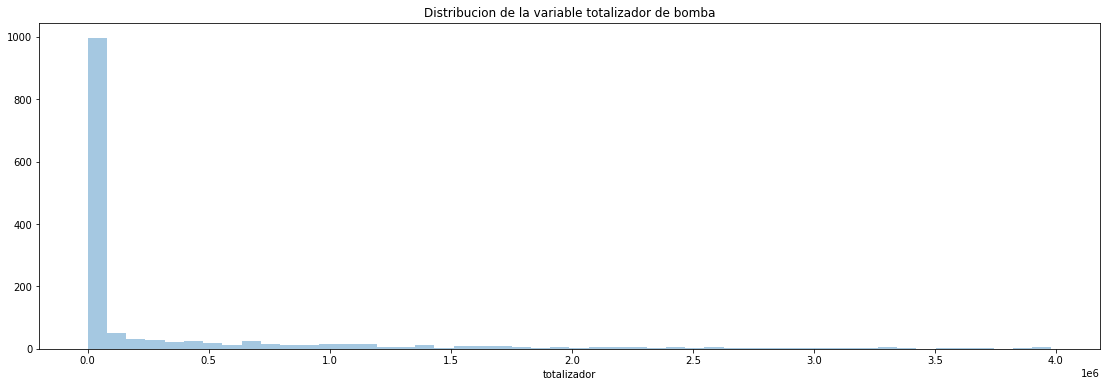

In [31]:
fig = plt.figure(figsize=(19,6))
data = df_bombas.totalizador
sns.distplot(data, kde=False, norm_hist=False)
plt.title("Distribucion de la variable totalizador de bomba")

No tiene mucho sentido ni valor obtener mediciones estadisticas de esta variables, pero a la vista del grafico que que tiene muchos valores en 0, podemos decir que en muchos casos no se utiliza la variable y por ende no se actualiza.

#### 2.3.- Intervalo entre logs de tanque

In [32]:
data = df_tanques
data.log_interval = pd.to_numeric(data.log_interval,errors='coerce')
data = data.dropna()
data.log_interval = data.log_interval.astype(int)

data.log_interval.describe()

count    1560.000000
mean       35.160256
std        81.999562
min         0.000000
25%        30.000000
50%        30.000000
75%        30.000000
max      2709.000000
Name: log_interval, dtype: float64

Vemos que al menos el 75% de los valores es menor  o igual que 30.y que el primer y tercer cuartil calen 30 pero esta metrica no es muy ultil, asique hayq que expresarla mejor

sondas con muestreo mayor a 30 minutos: 9.9 %
sondas con muestreo menor a 30 minutos: 8.3 %
sondas con muestreo cada 10 minutos: 5.4 %
sondas con muestreo cada 30 minutos: 81.8 %
sondas con muestreo cada 60 minutos: 9.4 %


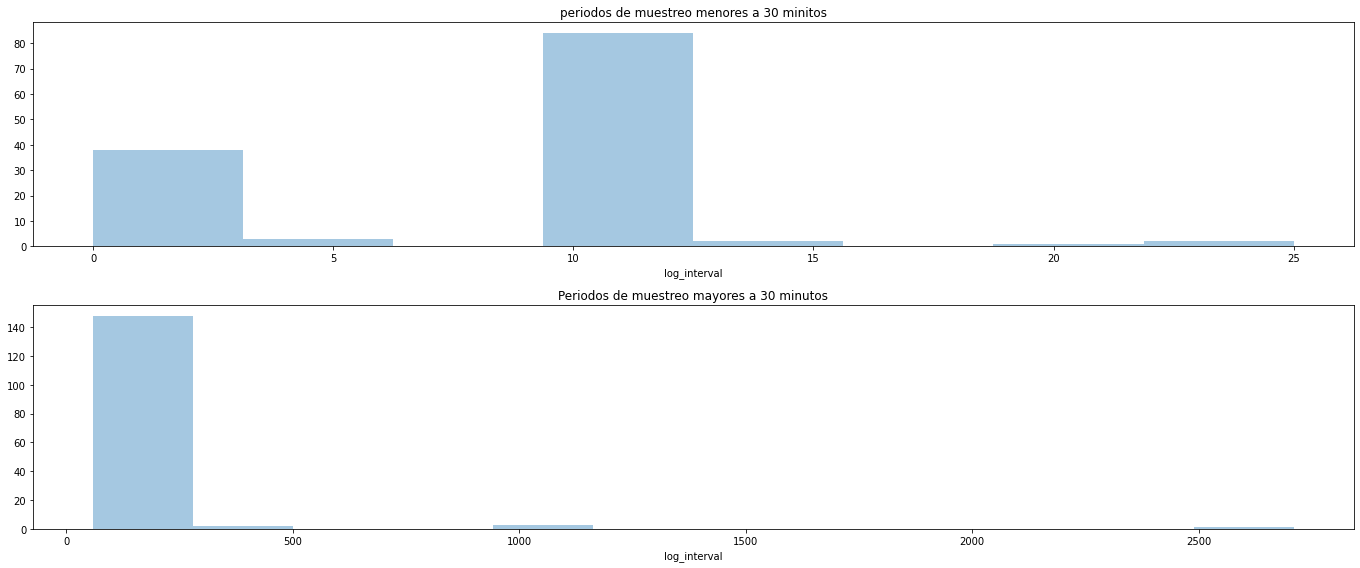

In [33]:
print("sondas con muestreo mayor a 30 minutos: %.1f %%" % (
        (100*len(data[data.log_interval > 30])/len(data)),
    )
)
print("sondas con muestreo menor a 30 minutos: %.1f %%" % (
        (100*len(data[data.log_interval < 30])/len(data)),
    )
)

print("sondas con muestreo cada 10 minutos: %.1f %%" % (
        (100*len(data[data.log_interval == 10])/len(data)),
    )
)

print("sondas con muestreo cada 30 minutos: %.1f %%" % (
        (100*len(data[data.log_interval == 30])/len(data)),
    )
)

print("sondas con muestreo cada 60 minutos: %.1f %%"  % (
        (100*len(data[data.log_interval == 60])/len(data)),
    )
)

fig = plt.figure(figsize=(19,8))
sp1 = plt.subplot('211')
sp1.set_title("periodos de muestreo menores a 30 minitos")
sns.distplot(data.log_interval[data.log_interval < 30], norm_hist=False, kde=False, ax=sp1)

sp2 = plt.subplot('212')
sp2.set_title('Periodos de muestreo mayores a 30 minutos')
sns.distplot(data.log_interval[data.log_interval > 30], norm_hist=False, kde=False, ax=sp2)

fig.tight_layout()

Se obserba de la descripcion y grafico anteriores que el ~80% de los equipos toma muestras de nivel de tanque cada 30 minutos, ~9% lo hace cada 60 minutos, y ~5% lo hace cada 10 minutos. El resto de los casos son clientes con requerimientos especificos, dispositivos experimentales o dispositivos mal configurados. Esta consideracion sera importante a la hora de matchear transacciones con historiales en la curacion

#### 2.4.-Cantidad de cargas totales de un usuario

Rango de la variable: 0 - 999


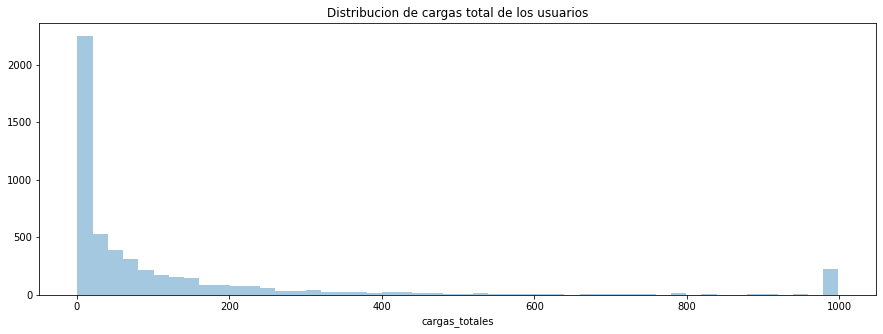

In [34]:
fig = plt.figure(figsize=(15,5))


data = df_usuarios
data.cargas_totales = data.cargas_totales.astype(int)
plt.title("Distribucion de cargas total de los usuarios")
print("Rango de la variable: {} - {}".format(data.cargas_totales.min(), data.cargas_totales.max()))
sns.distplot(data.cargas_totales[data.cargas_totales>0],kde=False, norm_hist=False)

Como vemos en el grafico, hay algunos usuarios con muchas cargas mientras otrso con pocas, esto no es real, ya que como se muestra en el rango y luego se aprecia en el grafico, esta variable toma valores de hasta tres digitos. Podemos afirmar entonces que la variable es incierta ya que cuando el valor supera 999 vuelve a 000 (overflow), entonces no podemos conocer el valor real. Por otro lado podremos obtener el valor de esta variable en un periodo de tiempo a partir de las tablas de transacciones ya que cada transaccion esta asociada a un usuario. a continuacion se muestra lo mencionado para todo el año 2019

In [35]:
# Cargo los datos de transaccion de 2019
query = " UNION ".join(
    ["SELECT id_transaccion, id_usuario, fecha FROM sis_transa_2019_{}".format(mes) for mes in range(1,13)]
)
df_transa_2019 = pd.read_sql(sql=query, con=path_conexion)
# elimiro registros espurios (con conocimiento de campo)
df_transa_2019 = df_transa_2019[(df_transa_2019.id_usuario!=0) & (df_transa_2019.fecha!='0000-00-00')]
df_transa_2019.fecha = pd.to_datetime(df_transa_2019.fecha)

In [36]:
# Obtengo la cantidad de cargas totales
data = df_transa_2019.groupby(['id_usuario']).count().rename(columns={'fecha':'cantidad'}).sort_index()
# obtengo el periodo activo del usuario
data['fecha_min'] = df_transa_2019.groupby(['id_usuario']).min().sort_index().fecha
data['fecha_max'] = df_transa_2019.groupby(['id_usuario']).max().sort_index().fecha
data['dias'] = (data.fecha_max-data.fecha_min).apply(lambda p: pd.Timedelta(p).days)
del data['id_transaccion']
# elimino los que tuvieron una carga eventual 
data = data[data.dias > 0]
data['cargas_por_dia'] = data.cantidad / data.dias
data

,cantidad,fecha_min,fecha_max,dias,cargas_por_dia
id_usuario,,,,,
380,1796,2019-01-03,2019-06-13,161,11.155280
381,4229,2019-01-02,2019-06-13,162,26.104938
432,504,2019-01-05,2019-12-22,351,1.435897
433,433,2019-01-03,2019-12-21,352,1.230114
441,581,2019-01-09,2019-12-28,353,1.645892
...,...,...,...,...,...
12699,100,2019-12-06,2019-12-31,25,4.000000
12707,1027,2019-12-01,2019-12-31,30,34.233333
12708,26,2019-12-01,2019-12-27,26,1.000000


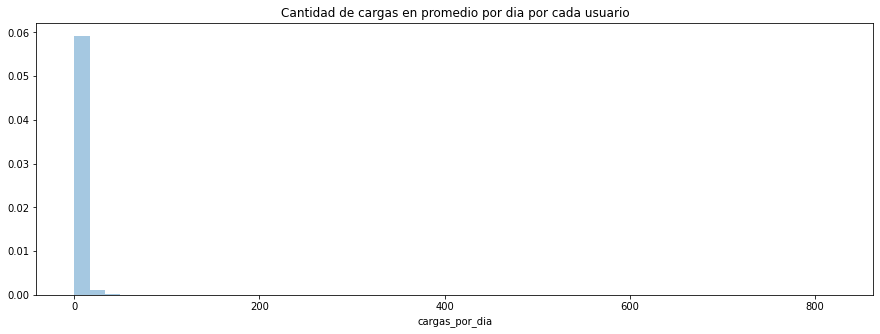

count    2754.000000
mean        2.468233
std        21.182581
min         0.007519
25%         0.124282
50%         0.241837
75%         0.574840
max       822.049451
Name: cargas_por_dia, dtype: float64

In [43]:
fig = plt.figure(figsize=(15,5))

plt.title("Cantidad de cargas en promedio por dia por cada usuario")
sns.distplot(data.cargas_por_dia, kde=False, norm_hist=True)
plt.show()
data.cargas_por_dia.describe()


La hipotesis que podemos generar partiendo del grafico anterior es que hay dos grupos de usuarios (dos usos para la variable), quienes realizan muchas transacciones de combustible (ej. playeros de estaciones de servicio), es decir que el usuario es quien despacha el combustible y por otro lado tenemos a usuarios que realizan pocas transacciones (ej. choferes), es decir que la variable esta asociada con quien recibe el combustible. 

Apoyandonos en la hipotesis anterior diremos que hay mas usuarios quienes reciben combustible que quienes despachan, el 75 porciento de los usuarios realizan menos de 18 cargas por mes, si descontamos los fines de semana y los feriados esto nos da aproximadamente 1 carga al dia. Intuitivamente podriamos afirmar que un chofer carga combustible dos veces al dia como maximo lo que puede servir como umbral para la diferenciacion de usuarios.

#### 2.5.-Produccion total de Biodiesel

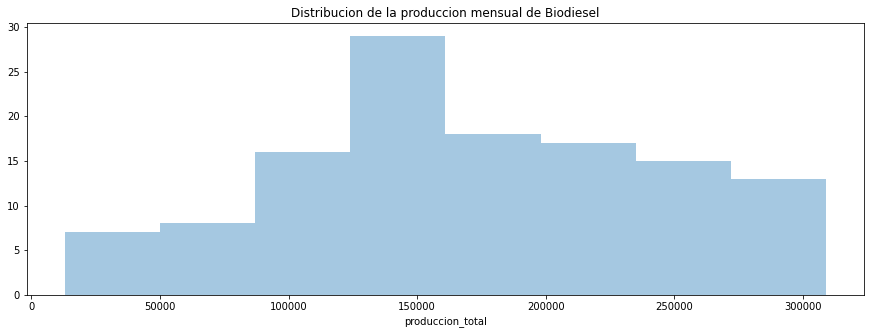

count       123.000000
mean     171548.249675
std       70834.659985
min       13119.000000
25%      124900.000000
50%      164382.000000
75%      226936.000000
max      308897.000000
Name: produccion_total, dtype: float64

In [45]:
fig = plt.figure(figsize=(15,5))

data = df_biodisel_nac

plt.title("Distribucion de la produccion mensual de Biodiesel")
sns.distplot(data.produccion_total, kde=False)
plt.show()

data.produccion_total.describe()

La produccion media mensual de biodiesel es de 171.5 KTon con desviacion estandar 70.8KTon , vemos que es asimetrica hacia la derecha, esto se debe a que la produccion ha aumentado a travez de los años y se muestra a continuacion

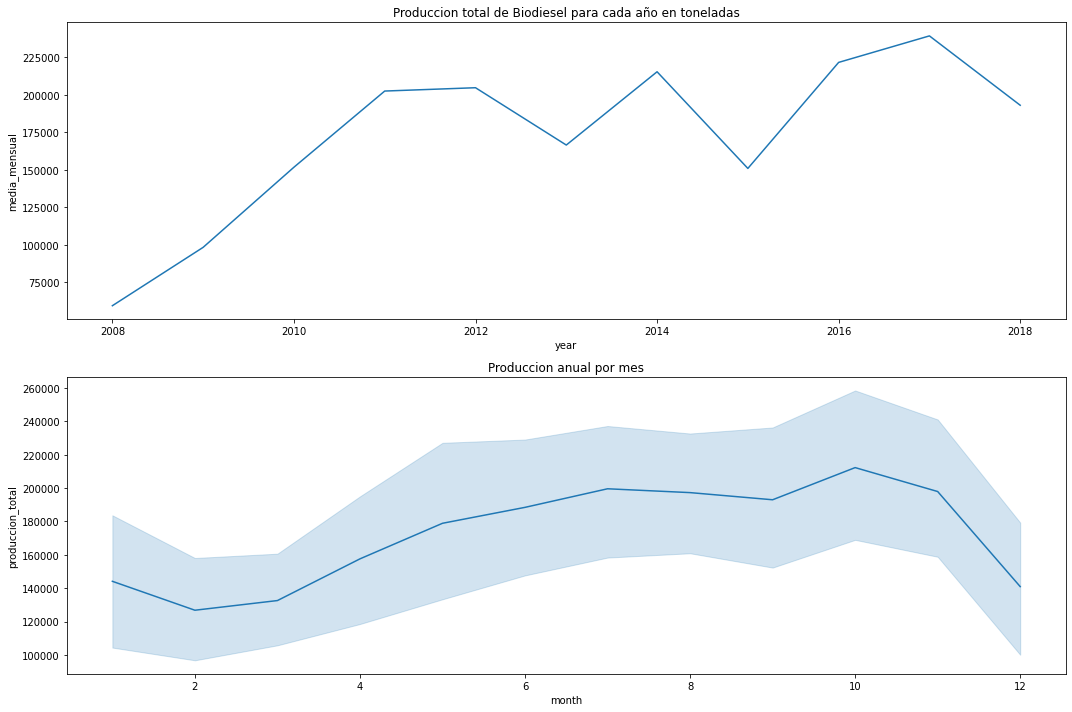

In [46]:
fig = plt.figure(figsize=(15,10))

data = df_biodisel_nac
data = data.rename(columns={'mes':'fecha'})
data['month'] = data.fecha.apply(lambda m: m.month)
data['year'] = data.fecha.apply(lambda y: y.year)

data2 = data.groupby(['year']).mean().reset_index(drop=False)
data2 = data2.rename(columns={'produccion_total':'media_mensual'})

sp2 = plt.subplot('211')
sp2.set_title('Produccion total de Biodiesel para cada año en toneladas')
sns.lineplot(data=data2, x='year', y='media_mensual',ax=sp2, 
             estimator=np.sum, ci=None)

sp1 = plt.subplot('212')
sp1.set_title('Produccion anual por mes')
sns.lineplot(data=data, x='month',y='produccion_total',ax=sp1)


fig.tight_layout()


En el primer grafico vemos la produccion total de biodiesel en cada año vemos que tuvo caidas importantes en los años 2013 y 2015 pero tiene una tendencia ascendente, parece haber una caida en 2018, sin embargo no podemos afirmarlo ya que solo tenemos datos hasta mayo de 2018.
En el segundo grafico se muestra la produccion media por mes, en este grafico se aprecia una alta estacionalidad de la produccion,en el rimer semestre la produccion es mucho menor que en el segundo.

### 3- Obtenga el número registros en el dataset para cada producto ('producto' de df_bombas). Comente sobre los valores obtenidos.

In [ ]:
print("cantidad de bombas: {}".format(
        len(df_bombas)
    )
)
print("cantidad de productos: {}".format(
        len(df_bombas[['id_equipo','producto']].drop_duplicates())
    )
)

Existen menos productos que bombas, esto nos indica que hay varias bombas que despachan un mismo producto

### 4- Obtener un gráfico para visualizar el comportamiento de los valores de capacidad de los tanques de combustibles. (df_tanques)

In [ ]:
fig = plt.figure(figsize=(15,5))
df_tanques.capacidad = pd.to_numeric(df_tanques.capacidad, errors='coerce')
data = df_tanques.dropna()

#hacer bins
data['capacidad_bins'] = pd.cut(data.capacidad,bins=list(range(0,110000,5000)))
data
sp = plt.subplot('111')
sp.set_title("Canridad de tanques agupados por rango de capacidad.")
sns.countplot(data=data,x='capacidad_bins', ax=sp,)
sp.set_xticklabels(sp.get_xticklabels(),rotation=90)
fig.tight_layout()
plt.show()
data.capacidad.describe()

Como muestra el grafico anterior, si bien tenemos tanques de hasta 100kLts. la capacidad del 75 % de los tanques es de hasta 50kLts. Sin embargo es muy representativa la cantidad de almacenamientos de baja capacidad (< 10kLts).

### 5- Obtener un gráfico que muestre y compare el comportamiento del coeficiente de variación de los distintos productos (df_productos). ¿Qué haría para mejorar el gráfico?

In [ ]:
# coeficiente de variacion de volumen
df_productos.coef_var_vol.unique()

In [ ]:
fig = plt.figure(figsize=(15,5))

sp = plt.subplot('111')
sns.countplot(data=df_productos, x='coef_var_vol',ax=sp)

data = df_productos.coef_var_vol.dropna()

print(
    "Productos con coheficiente de dilatacion 0.001 : {}%".format(
        (100 * len(data[data == 0.001])/len(data))
    )
)
# hay muchos productos con el mismo coheficiente.

Hay muchos productos con el mismo coeficiente, asique vamos a analizar a que productos corresponde.

In [ ]:
data.nombre_producto.value_counts()

In [ ]:
fig = plt.figure(figsize=(15,10))
data = df_productos[df_productos.coef_var_vol == 0.001]
data.nombre_producto = data.nombre_producto.str.upper().apply(lambda n: 'DIESEL' if re.match(r'.*(DIESEL|GAS\s{0,1}OIL|EURO|D500).*',n) else n)
data.nombre_producto = data.nombre_producto.apply(lambda n: 'NAFTA' if re.match(r'.*(NAFTA|SUPER|ENERGY).*',n) else n)
data.nombre_producto = data.nombre_producto.apply(lambda n: 'DESCONOCIDO' if re.match(r'.*(PRODUCT|N/A).*',n) else n)

sp = plt.subplot('211')
sp.set_title("Productos con coheficiente de dilatacion = 0.001 (todos)")
sns.countplot(
    data=data, x='nombre_producto',ax=sp,
    order=data.nombre_producto.value_counts().index
)
sp.set_xticklabels(sp.get_xticklabels(), rotation=90)

sp1 = plt.subplot('212')
sp.set_title("Productos con coheficiente de dilatacion = 0.001 (Solo Conocidos)")
sns.countplot(
    data=data[data.nombre_producto != 'DESCONOCIDO'], x='nombre_producto',ax=sp1,
    order=data.nombre_producto[data.nombre_producto != 'DESCONOCIDO'].value_counts().index
)
sp1.set_xticklabels(sp1.get_xticklabels(), rotation=90)

fig.tight_layout()

Del grafico anterior concluimos que no podemos inferir a que producto real (diesel, gasoil, nafta, etc.) corresponden los que no tienen nombre , ej. "PRODUCTO 1",
ya que son muchos los productos con el mismo coeficiente.

### 6- Analizar la distribución de los litros totales y la cantidad de cargas totales que suministraron los usuarios ('totalizador' y 'cargas_totales' del df_usuarios)

In [ ]:
data = df_usuarios
data.cargas_totales = data.cargas_totales.astype(int)
data.totalizador = data.totalizador.astype(float)

fig = plt.figure(figsize=(15,5))
sp1 = plt.subplot('211')
sp1.set_title("Cantidad de cargas")
sns.distplot(data.cargas_totales,kde=False, norm_hist=False, ax=sp1)

sp2 = plt.subplot('212')
sp2.set_title("Cantidad de litros despachados")
sns.distplot(data.totalizador,kde=False, norm_hist=False, ax=sp2, label='volumen suministrado[Lts]')

fig.tight_layout()
plt.show()

data.totalizador.describe()

Como ya se explico en el item 2.4, esta variable esta corrupta, debido a la limitacion de tres cifras se genera un overflow de la variable por eso este dato es incierto, el valor correcto puede obtenerse analizando la tabla de transacciones en un periodo de tiempo.
Lo mismo sucede con la vaiable totalizador, esta limitada a 5 cifras, esto genera oveflow y la variable se reinicia. no es confiable. Sin embargo podemos obtener el valor de la variable en un periodo de tiempo, idem a la variable cargas_totales.

In [ ]:
# Cargo los datos de transaccion de 2019
query = " UNION ".join(
    ["SELECT id_transaccion, id_usuario, fecha, cantidad FROM sis_transa_2019_{}".format(mes) for mes in range(1,13)]
)
df_transa_2019 = pd.read_sql(sql=query, con=path_conexion)
# elimiro registros espurios (con conocimiento de campo)
df_transa_2019 = df_transa_2019[(df_transa_2019.id_usuario!=0) & (df_transa_2019.fecha!='0000-00-00')]
df_transa_2019.fecha = pd.to_datetime(df_transa_2019.fecha)
df_transa_2019.cantidad = pd.to_numeric(df_transa_2019.cantidad, errors='coerce')
df_transa_2019 = df_transa_2019.dropna()
# Elimino transacciones con cantidad = 0
df_transa_2019 = df_transa_2019[df_transa_2019.cantidad > 0]

In [ ]:
data = df_transa_2019.groupby(['id_usuario']).sum().sort_index()
# obtengo el periodo activo del usuario
data['fecha_min'] = df_transa_2019.groupby(['id_usuario']).min().sort_index().fecha
data['fecha_max'] = df_transa_2019.groupby(['id_usuario']).max().sort_index().fecha
# cantidad de dias que el usuario estuvo activo 
data['dias'] = df_transa_2019[['id_usuario','fecha']].drop_duplicates().groupby(['id_usuario']).count().sort_index().fecha
del data['id_transaccion']
# elimino los que tuvieron una carga eventual 
data = data[data.dias > 0]

data['cantidad_por_dia'] = data.cantidad / data.dias
data['cargas_totales'] = df_transa_2019.groupby(['id_usuario']).count().id_transaccion.sort_index()
data['cargas_por_dia'] = data.cargas_totales / data.dias

data.cargas_por_dia.describe()

Como se menciono en el punto 2.4, es logico pensar que podemos diferenciar los grupos de usuarios umbralizando en cargas_por_dia = 2 es decir que un quien recibe el combustible carga como maximo dos veces al dia. esta hiposis se prueba obserbando que el terver cuartil tiene valor 2.0 

In [ ]:
fig = plt.figure(figsize=(15,10))
data['grupo'] = np.where(data.cargas_por_dia <= 2, "Grupo 1", "Grupo 2")

sp1 = plt.subplot("211")
sp1.set_title("cantidad promedio de cargas  por dia vs volumen promedio de la transaccion por dia ")
sns.scatterplot(data=data, x='cargas_por_dia', y='cantidad_por_dia', hue='grupo', ax=sp1)

sp2 = plt.subplot("212")
sp2.set_title("Cantidad promedio de cargas  por dia vs volumen promedio de la transaccion por dia (Grupo 1)")
sns.scatterplot(data=data[data.grupo == 'Grupo 1'], x='cargas_por_dia', y='cantidad_por_dia', ax=sp2)

fig.tight_layout()

En el Scaterplot anterior se muestra la relacion entre las variables 'cantidad de cargas por dia' y 'volumen cargado por dia'. para el Grupo dos existe una correlacion positiva de las variables, mientras que para el grupo uno, no hay una correlacion evidente.

## Emplear los datos públicos del Bioetanol y Biodiesel: producción y ventas (total país), en las últimos planteamientos:

### 7- Obtener las gráficas de series temporales de la producción de bioetanol en base a caña de azúcar, a maíz y la total, así también para la producción total de biodiesel.

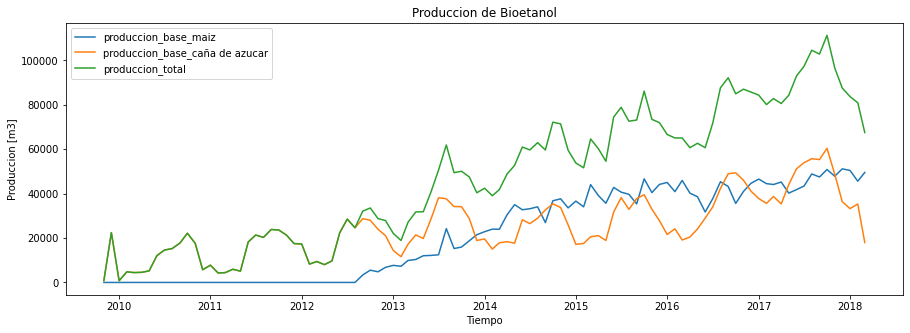

In [61]:
fig = plt.figure(figsize=(15,5))

plt.title("Produccion de Bioetanol")
sns.lineplot(data=bioetanol_nacional, x='mes', y='produccion_base_maiz',label="produccion_base_maiz" )
sns.lineplot(data=bioetanol_nacional, x='mes', y='produccion_base_cana_de_azucar',label="produccion_base_caña de azucar")
sns.lineplot(data=bioetanol_nacional, x='mes', y='produccion_total',label="produccion_total")
plt.ylabel("Produccion [m3]")
plt.xlabel("Tiempo")
plt.legend()

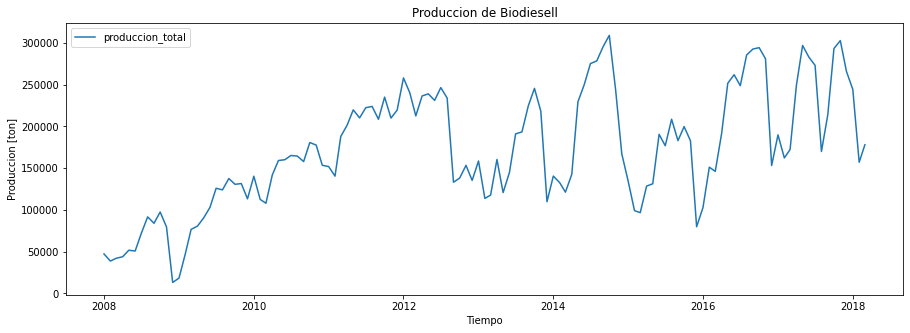

In [65]:
fig = plt.figure(figsize=(15,5))

plt.title("Produccion de Biodiesell")
sns.lineplot(data=df_biodisel_nac, x='mes', y='produccion_total',label="produccion_total")
plt.ylabel("Produccion [ton]")
plt.xlabel("Tiempo")
plt.legend()

### 8- Comparar la distribución de producción total de biodiesel y bioetanol para cada mes y año. ¿En qué años y meses los consumos son más consistentes?
--> Emplear: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html#pandas.pivot_table

### 9- Obtener un mapa de calor por mes y año, para los valores medios de  producción total de biodiesel y bioetanol.